### Downlaoding the kaggle dataset into colab

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kmader/skin-cancer-mnist-ham10000
! unzip skin-cancer-mnist-ham10000

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv('/content/drive/My Drive/skin-cancer-detection/hmnist_28_28_RGB.csv')

print(df.head())

   pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166

In [8]:
# Extract features (pixel values) and labels
X = df.iloc[:, :-1].values  # Features (all columns except the last one)
y = df.iloc[:, -1].values   # Labels (last column)

In [6]:
len(X)

10015

In [6]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
X,y  = oversample.fit_resample(X,y)

### Before executing the PCA algorithm we need to standardize the scale since it is sensetive to the scale and the magnitutde of the features.
### The accuracy of the model was best when the number of components were between 25 and 32 (based on personal tests)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), slice(0, -1)),
        ('pca', PCA(n_components=30), slice(0, -1)),
    ],
)

prepared_data = pipeline.fit_transform(X)

In [ ]:
prepared_data

array([[ 1.83175494e-01,  4.72269417e-01,  1.06347865e+00, ...,
         8.63915723e+01,  2.66329174e+02, -1.20657606e+02],
       [-2.61209759e+00, -2.61379236e+00, -2.28559055e+00, ...,
         6.58120892e+01, -8.03137325e+01,  7.63782615e+00],
       [ 1.83175494e-01,  1.39241167e-01,  2.41621173e-01, ...,
        -6.85741791e+01, -8.35912532e+00,  1.12753469e+01],
       ...,
       [-8.21114237e-01, -3.04796499e-01, -4.77504115e-01, ...,
        -9.29775917e+00,  6.17024339e+01,  1.58436782e+02],
       [-3.52445696e-01, -1.71585199e-01,  9.77961155e-02, ...,
         2.30791499e+01, -4.40904108e+01,  6.12059312e+01],
       [-1.01373263e-01,  2.28048701e-01, -4.15864805e-01, ...,
        -3.96425822e+01, -6.00428562e+01,  4.66490359e+01]])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(prepared_data, y, test_size=0.2, random_state=42)


In [ ]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf}')

print('Classification Report:')
print(classification_report(y_test, y_pred_rf, zero_division=1))

Random Forest Accuracy: 0.987003302439544
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1295
           1       0.99      1.00      0.99      1323
           2       0.96      1.00      0.98      1351
           3       1.00      1.00      1.00      1392
           4       0.99      0.92      0.95      1346
           5       1.00      1.00      1.00      1292
           6       0.97      0.99      0.98      1388

    accuracy                           0.99      9387
   macro avg       0.99      0.99      0.99      9387
weighted avg       0.99      0.99      0.99      9387



### Using grid search helps tuning the parameters for obtaining the best accuracy from the model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

rf_model_tuned = RandomForestClassifier(random_state=42)

randomized_search_rf = RandomizedSearchCV(rf_model_tuned, param_distribs, cv=5, scoring='accuracy')

randomized_search_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest: ", randomized_search_rf.best_params_)
print("Best Accuracy for Random Forest: ", randomized_search_rf.best_score_)

Best Parameters for Random Forest:  {'max_features': 6, 'n_estimators': 156}
Best Accuracy for Random Forest:  0.9815169900868181


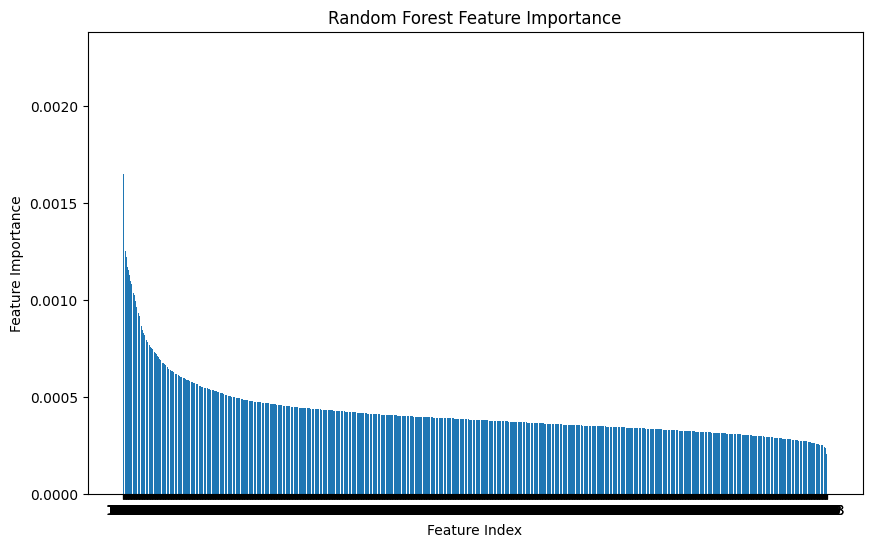

In [ ]:
import matplotlib.pyplot as plt

feature_importances = randomized_search_rf.best_estimator_.feature_importances_

indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


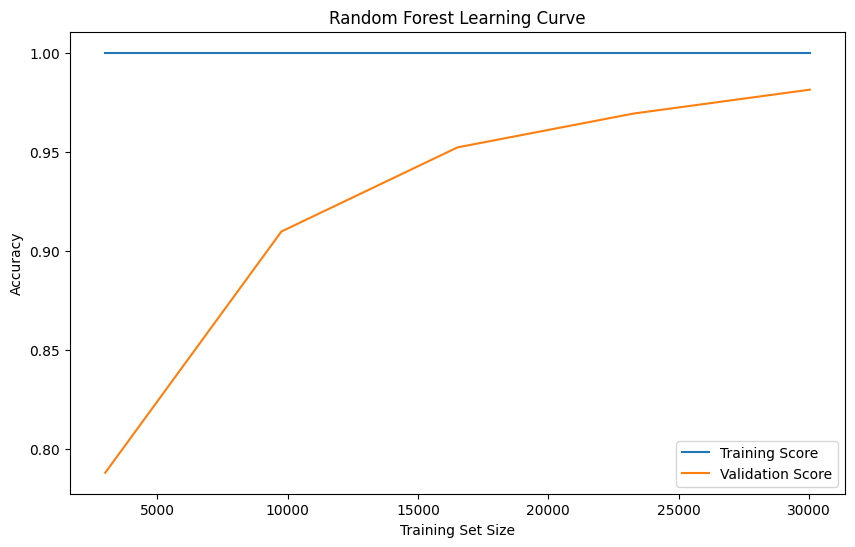

In [ ]:
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(randomized_search_rf.best_estimator_, X_train, y_train, cv=5)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Random Forest Learning Curve')
plt.legend()
plt.show()


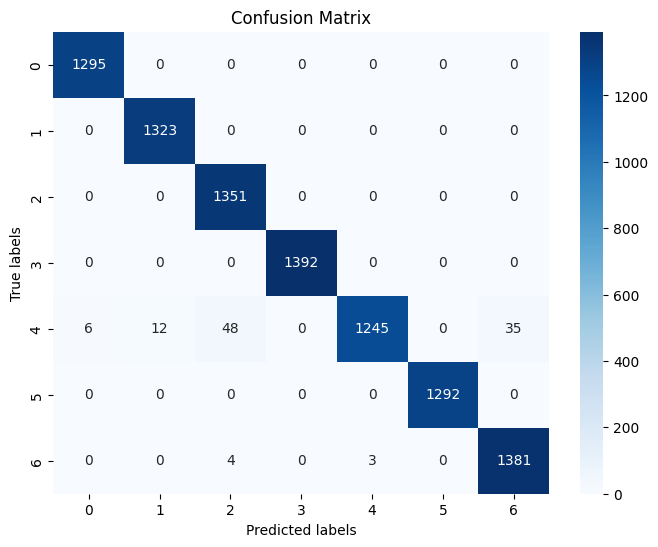

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = randomized_search_rf.predict(X_test).round()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC

svm_model = LinearSVC(C=1, loss="hinge")
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.6000998502246631
Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.04      0.06        69
           1       0.22      0.60      0.32        93
           2       0.29      0.31      0.30       228
           3       0.00      0.00      0.00        28
           4       0.78      0.77      0.78      1338
           5       0.04      0.05      0.04        21
           6       0.30      0.18      0.22       226

    accuracy                           0.60      2003
   macro avg       0.25      0.28      0.25      2003
weighted avg       0.60      0.60      0.60      2003



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

In [ ]:
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(svm_model, X_train, y_train, cv=5)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('SVM Learning Curve')
plt.legend()
plt.show()

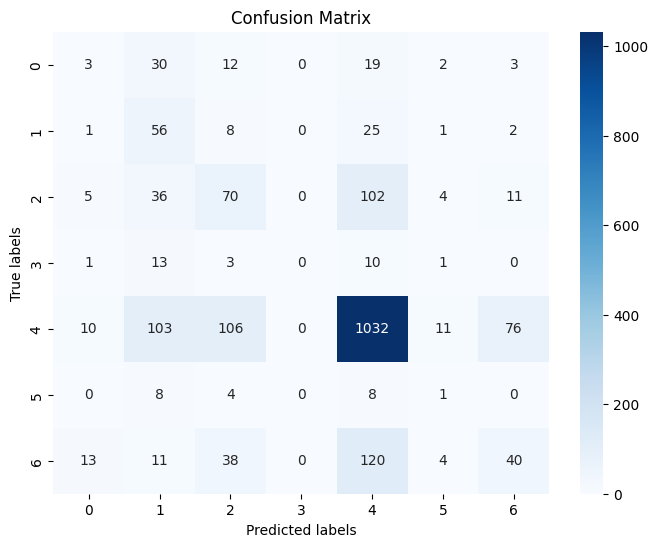

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = svm_model.predict(X_test).round()

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()